In [134]:
import tensorflow as tf

Note: you may need to restart the kernel to use updated packages.


In [135]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


In [9]:
dataset= nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to C:\Users\issam\.cache\huggingface\datasets\emotion\default\0.0.0\84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [136]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [11]:
train = dataset['train']
test = dataset['test']
validation = dataset['validation']

In [36]:
def get_tweet(data):
    texts = data['text']
    labels = data['label']
    return texts,labels

In [41]:
texts,labels =get_tweet(train)


('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

In [42]:
#Tokenizer : map each word to a number
from tensorflow.keras.preprocessing.text import Tokenizer

In [44]:
#we will have 10K most repeated words, and all of the unmapped words will have the '<UNK>' key
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>') 
tokenizer.fit_on_texts(texts)

In [69]:
tokenizer.word_counts
tokenizer.index_word #sequences

{1: '<UNK>',
 2: 'i',
 3: 'feel',
 4: 'and',
 5: 'to',
 6: 'the',
 7: 'a',
 8: 'feeling',
 9: 'that',
 10: 'of',
 11: 'my',
 12: 'in',
 13: 'it',
 14: 'like',
 15: 'so',
 16: 'for',
 17: 'im',
 18: 'me',
 19: 'but',
 20: 'was',
 21: 'have',
 22: 'is',
 23: 'this',
 24: 'am',
 25: 'with',
 26: 'not',
 27: 'about',
 28: 'be',
 29: 'as',
 30: 'on',
 31: 'you',
 32: 'just',
 33: 'at',
 34: 'when',
 35: 'or',
 36: 'all',
 37: 'because',
 38: 'more',
 39: 'do',
 40: 'can',
 41: 'really',
 42: 'up',
 43: 't',
 44: 'are',
 45: 'by',
 46: 'very',
 47: 'know',
 48: 'been',
 49: 'if',
 50: 'out',
 51: 'myself',
 52: 'time',
 53: 'how',
 54: 'what',
 55: 'get',
 56: 'little',
 57: 'had',
 58: 'now',
 59: 'will',
 60: 'from',
 61: 'being',
 62: 'they',
 63: 'people',
 64: 'them',
 65: 'would',
 66: 'he',
 67: 'want',
 68: 'her',
 69: 'some',
 70: 'think',
 71: 'one',
 72: 'still',
 73: 'ive',
 74: 'him',
 75: 'even',
 76: 'who',
 77: 'an',
 78: 'life',
 79: 'its',
 80: 'make',
 81: 'there',
 82: 'w

In [68]:
print(texts[0])
tokenizer.texts_to_sequences([texts[0]])

i didnt feel humiliated


[[2, 139, 3, 679]]

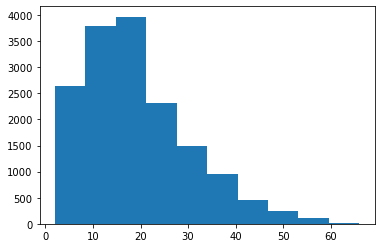

In [84]:
## padding and truncating
lengths = [len(t.split(' ')) for t in texts] #getting each sentence length
plt.hist(lengths)
plt.show()
#we can see most of the lengths are between 8 to 20 words

In [85]:
# we have to make our input have the same length
maxlen = 50 #most of our texts are <= than 50 words
#we will pad texts with less than 50, and truncate with more than 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [104]:
def get_sequence(tokenizer,texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
    return padded
#'post' parameter so the operations of padding and truncating are at the end

In [87]:
padded_train = get_sequence(tokenizer,texts)

In [91]:
#text smaller than 50
print(texts[0])
print(tokenizer.texts_to_sequences([texts[0]]))
padded_train[0]

i didnt feel humiliated
[[2, 139, 3, 679]]


array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [103]:
for i in range(len(texts)):
    if len(texts[i].split(' ')) > 50:
        break

print(tokenizer.texts_to_sequences([texts[i]])
      ,'\n Length = ',len(tokenizer.texts_to_sequences([texts[i]])[0]))
padded_train[i]

[[2, 72, 85, 11, 15, 4, 362, 6, 299, 16, 74, 2, 40, 96, 457, 3063, 6, 1688, 9, 7407, 99, 30, 133, 680, 4, 6, 310, 9, 22, 99, 1291, 11, 15, 106, 7, 629, 264, 171, 76, 22, 26, 112, 369, 168, 5, 6, 63, 128, 74, 34, 66, 22, 8, 233]] 
 Length =  54


array([   2,   72,   85,   11,   15,    4,  362,    6,  299,   16,   74,
          2,   40,   96,  457, 3063,    6, 1688,    9, 7407,   99,   30,
        133,  680,    4,    6,  310,    9,   22,   99, 1291,   11,   15,
        106,    7,  629,  264,  171,   76,   22,   26,  112,  369,  168,
          5,    6,   63,  128,   74,   34])

In [106]:
#encoding labels
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

<function matplotlib.pyplot.show(close=None, block=None)>

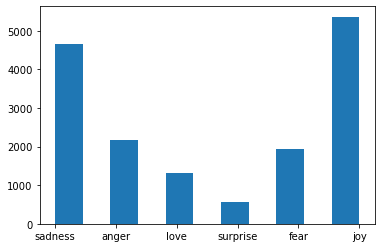

In [110]:
plt.hist(labels,bins=11)
plt.show
#data imbalance 


In [119]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class =dict((v,k) for k,v in class_to_index.items())

In [127]:
class_to_index

{'love': 0, 'anger': 1, 'surprise': 2, 'fear': 3, 'sadness': 4, 'joy': 5}

In [123]:
names_to_ids = lambda labels : np.array([class_to_index.get(x) for x in labels])

In [130]:
train_labels = names_to_ids(labels)
print(labels[0])
train_labels[0]


sadness


16000

In [137]:
#Modeling 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM,Dense

In [138]:
model = Sequential([
    Embedding(10000,16,input_length=maxlen),
    Bidirectional(LSTM(20,return_sequences=True)),
    Bidirectional(LSTM(20)),
    Dense(6,activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [140]:
model.summary() #10k are our tokenized words, 6 dense we got 6 labels

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [142]:
#training the model
val_texts,val_labels = get_tweet(validation)
val_seq = get_sequence(tokenizer,val_texts)
val_labels = names_to_ids(val_labels)

In [146]:
print(validation[0])
print(val_texts[0],val_labels[0])

{'label': 'sadness', 'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon'}
im feeling quite sad and sorry for myself but ill snap out of it soon 4


In [147]:
trained_model = model.fit(
padded_train, train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)]
)

Epoch 1/20
500/500 [==============================] - 19s 23ms/step - loss: 1.5674 - accuracy: 0.3411 - val_loss: 1.1031 - val_accuracy: 0.5660
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.8734 - accuracy: 0.6599 - val_loss: 0.5611 - val_accuracy: 0.8250
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3765 - accuracy: 0.8808 - val_loss: 0.4203 - val_accuracy: 0.8655
Epoch 4/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2219 - accuracy: 0.9271 - val_loss: 0.4565 - val_accuracy: 0.8630
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1553 - accuracy: 0.9495 - val_loss: 0.4153 - val_accuracy: 0.8830
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1136 - accuracy: 0.9659 - val_loss: 0.3809 - val_accuracy: 0.8855
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.0886 - accuracy: 0.9720 - val_loss: 0.4098 - val_accuracy:

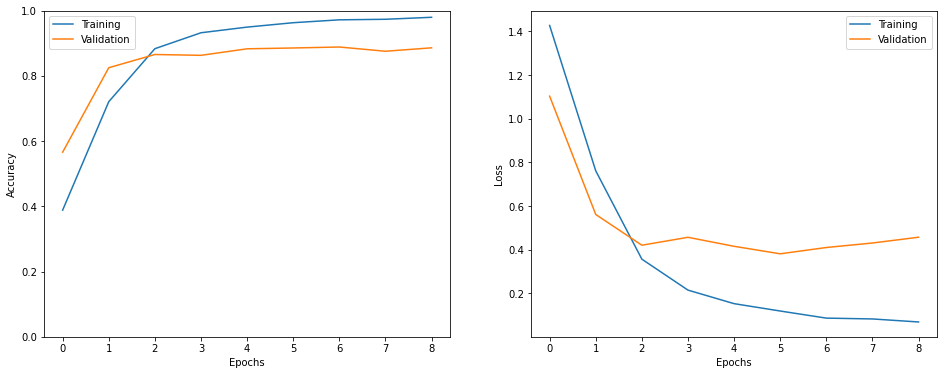

In [150]:
#model evaluation
show_history(trained_model)

In [152]:
test_texts,test_labels = get_tweet(test)
test_seq = get_sequence(tokenizer,test_texts)
test_labels = names_to_ids(test_labels)


In [155]:
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 11ms/step - loss: 0.4114 - accuracy: 0.8855


In [170]:
print('Sentence : ',test_texts[0])
print('Emotion : ',index_to_class[test_labels[0]])
p = model.predict(np.expand_dims(test_seq[0],axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted :', pred_class)

Sentence :  im feeling rather rotten so im not very ambitious right now
Emotion :  sadness
Predicted : sadness


In [188]:
p = model.predict(test_seq)
print('Sentence : ',test_texts[0])
print('Emotion : ',index_to_class[test_labels[0]])
index_to_class[np.argmax(p[0])]
c = 0
for i in range(len(test_seq)):
    if index_to_class[test_labels[i]] == index_to_class[np.argmax(p[i])] :
        c+=1
print(c,len(test_seq), c/len(test_seq))   


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Sentence :  im feeling rather rotten so im not very ambitious right now
Emotion :  sadness
159 2000 0.0795


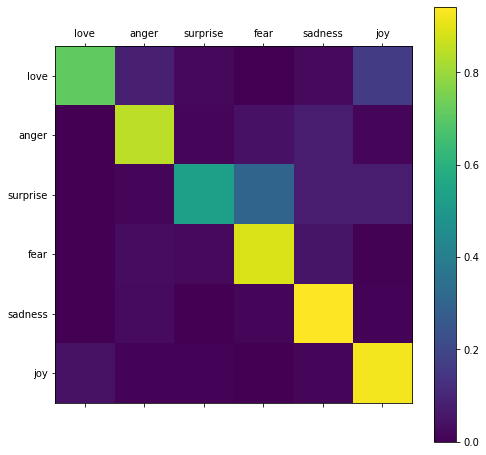

In [191]:
p = np.argmax(model.predict(test_seq),axis=-1)
show_confusion_matrix(test_labels,p,list(classes))

# we have some issues in the surprise/fear